In [2]:
# Packages have to go in this order... I don't know why

import numpy as np
import pandas as pd
import xarray as xr
import eofs
from eofs.standard import Eof
import glob



# You need intake-esm V 2020.11.4 and intake V 0.6.0

# import tensorflow as tf

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely.geometry.polygon import LinearRing


import matplotlib as mpl
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from matplotlib import cm

import copy
import fsspec
import pop_tools



## Functions

In [3]:
def plot_global_corr(field,lons,lats,title):
    plot_field= field.squeeze()
    lon =lons
    lat= lats

    plt.figure(figsize=(25, 20))
    proj = ccrs.PlateCarree(central_longitude=0)
    #proj = ccrs.PlateCarree(central_longitude=180)
    ax1 = plt.subplot(1, 1, 1, projection=proj)
    ax1.coastlines('50m')
    clevsRWS=np.arange(-1,1.05,.05) 
    haa = cm.get_cmap("Greys",len(clevsRWS))
    haa = haa(np.linspace(0,1,len(clevsRWS)))
    white=[1,1,1,1]
    haa[:3,:] = white
    #either do this 
    cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
    #or set an ocean nanmask! 
    nanmask = np.zeros_like(plot_field)+1
    
    #plt.contourf(lon-180, lat, (plot_field),levels=clevsRWS,
    plt.contourf(lon, lat, (plot_field),levels=clevsRWS,
            cmap='RdBu', transform=proj)
    plt.plot([0-180,360-180],[0,0],color='k',linewidth=1,linestyle='--',zorder=1)
    
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='10m',
        facecolor='none')

    ax1.set_xticks([20,60,100,140,180,220,260,300,340], crs=ccrs.PlateCarree())
    ax1.set_yticks(np.arange(-80,90,20), crs=ccrs.PlateCarree())

    lon_formatter = LongitudeFormatter(zero_direction_label=True,number_format='.0f')
    lat_formatter = LatitudeFormatter()
    ax1.xaxis.set_major_formatter(lon_formatter)
    ax1.yaxis.set_major_formatter(lat_formatter)
    ax1.tick_params(labelsize=30) 
    ax1.set_extent([0,359,-85,85], crs=ccrs.PlateCarree())
    # ax1.add_feature(states_provinces, edgecolor='black')
    ax1.add_feature(cartopy.feature.BORDERS,edgecolor='black')
    plt.title(title,fontsize=30)
    plt.colorbar(shrink=0.45)
    plt.show()
    
def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))





def PNA_NPO_PCS(files,season_months,varnam):
    DS = files
    for cnt,mons in enumerate(season_months):
        print('doing: ',mons)
        
        print('...opening/selecting month!...')
        seasonALL  = DS.sel(time = np.in1d(DS['time.month'], mons))
        print('... slicing to region ...')
        season1=seasonALL.sel(lat=slice(20,85),lon=slice(120,240))
        print('... Time Mean ...')
        Z500 = np.array(season1.groupby('time.year').mean('time')[varnam].data)
        print('...creating anomaly...')
        TEMP = Z500-np.expand_dims(np.mean(Z500,axis=0),axis=0)  #### CHECK THIS!!!!!!!!#### CHECK THIS!!!!!!!!

        #set up weights 
        lats = season1['lat'].data
        lons = season1['lon'].data
        coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
        wgts = np.sqrt(coslat)[..., np.newaxis]
        wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
        wgts = np.expand_dims(wgts,axis=0)
        ##

        print('...Decomposing Modes...')
        solver = Eof(TEMP, weights=wgts)
        eof = solver.eofsAsCorrelation(neofs=3)
        pcs = solver.pcs(npcs = 2,)    
        
        print('...loading daily...')
        dailyZ500 = np.array(season1.ZG.data)
        dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
        pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
        pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

    
        #check to make sure it's the correct direction of magnitude.
        lo1 = np.argmin(np.abs(150-lons))
        lo2 = np.argmin(np.abs(210-lons))
        la1 = np.argmin(np.abs(30-lats))
        la2 = np.argmin(np.abs(55-lats))
        print('sum eof PNA:',np.sum(eof[0,la1:la2,lo1:lo2]))
        if np.sum(eof[0,la1:la2,lo1:lo2])>0:
            print('flipping PNA',mons)
            pseudo_pcs[:,0]=-1*pseudo_pcs[:,0]
        
        
        lo1 = np.argmin(np.abs(140-lons))
        lo2 = np.argmin(np.abs(220-lons))
        la1 = np.argmin(np.abs(25-lats))
        la2 = np.argmin(np.abs(50-lats))
        print('sum eof NPO:',np.sum(eof[1,la1:la2,lo1:lo2]))
        if np.sum(eof[1,la1:la2,lo1:lo2])>0:
            print('flipping NPO',mons)
            pseudo_pcs[:,1]=-1*pseudo_pcs[:,1]
    
        print('..loading global...')
        globalZ500 = np.array(seasonALL.ZG.data)
        globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

        eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
        #eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

        print('correlating')
        for lala in range(globalZ500.shape[1]):
            for lolo in range(globalZ500.shape[2]):
                eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
                #eof_corr2[lala,lolo]=np.corrcoef(pseudo_pcs[:,1],globalZ500[:,lala,lolo])[0,1]
    
        #plotting
        mon_string = listToString(list(map(str, mons)))
        plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data,'PNA months:'+mon_string)
    
    
        if cnt==0:
            #turn psuedo pcs in to xarray ds 
            DS_indices = xr.Dataset(
            {
                "PNA": (["time"], pseudo_pcs[:,0].squeeze()),
                "NPO": (["time"], pseudo_pcs[:,1].squeeze())
            },
            coords={
                "time": season1.time.data,
            },
            )
        else:
            TempDS = xr.Dataset(
            {
                "PNA": (["time"], pseudo_pcs[:,0].squeeze()),
                "NPO": (["time"], pseudo_pcs[:,1].squeeze())
            },
            coords={
                "time": season1.time.data,
            },
            )
            DS_indices=xr.merge([DS_indices,TempDS])
        
    return DS_indices





In [4]:
def NAO_PCS(files,season_months,varnam):
    #DS = xr.open_mfdataset(files,combine='by_coords')
    DS = files
    for cnt,mons in enumerate(season_months):
        print('doing: ',mons)

        seasonALL  = DS.sel(time = np.in1d(DS['time.month'], mons))
        #have to roll the dataset. 
        print('... rolling DS...')
        ds_rolled = seasonALL.assign_coords(lon=(seasonALL.lon % 360)).roll(lon=(seasonALL.dims['lon'] // 2),roll_coords=True)
        print('... slicing to region ...')
        season1 = ds_rolled.sel(lat=slice(20,80),lon=slice(270,40))
        print('... Time Mean ...')
        #Z500 = np.array(season1.groupby('time.year').mean('time')['TAS'].data)
        Z500 = np.array(season1.groupby('time.year').mean('time')['ZG'].data)
        print('...creating anomaly...')
        TEMP = Z500-np.expand_dims(np.mean(Z500,axis=0),axis=0) #### CHECK THIS!!!!!!!!
    
        #set up latitudinally weighting 
        lats = season1['lat'].data
        lons = season1['lon'].data
        coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
        wgts = np.sqrt(coslat)[..., np.newaxis]
        wgts=np.repeat(wgts[None,...],lons.shape[0],0).squeeze().T
        wgts = np.expand_dims(wgts,axis=0)
        ##


        print('...Decomposing Modes...')
        solver = Eof(TEMP, weights=wgts)
        eof = solver.eofsAsCorrelation(neofs=3)
        pcs = solver.pcs(npcs = 2,)    
    
        print('...loading daily...')
        #dailyZ500 = np.array(season1.TAS.data)
        dailyZ500 = np.array(season1.ZG.data)
        dailyZ500 = dailyZ500 - np.mean(dailyZ500,axis=0)
        pseudo_pcs = solver.projectField(dailyZ500, neofs=3)
        pseudo_pcs = (pseudo_pcs/np.std(pseudo_pcs,axis=0))

    
        #check to make sure it's the correct direction of magnitude.

        la1 = np.argmin(np.abs(50-lats))
        la2 = np.argmin(np.abs(80-lats))
        print('sum eof NAO:',np.sum(eof[0,la1:la2,:]))
        if np.sum(eof[0,la1:la2,:])>0:
            print('flipping PNA',mons)
            pseudo_pcs[:,0]=-1*pseudo_pcs[:,0]
        
        print('..loading global...')
        #globalZ500 = np.array(seasonALL.TAS.data)
        globalZ500 = np.array(seasonALL.ZG.data)
        globalZ500 = globalZ500- np.mean(globalZ500,axis=0)

        eof_corr1=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])
        eof_corr2=np.zeros([globalZ500.shape[1],globalZ500.shape[2]])

        print('correlating')
        for lala in range(globalZ500.shape[1]):
            for lolo in range(globalZ500.shape[2]):
                eof_corr1[lala,lolo]=np.corrcoef(pseudo_pcs[:,0],globalZ500[:,lala,lolo])[0,1]
    
        #plotting
        mon_string = listToString(list(map(str, mons)))
        plot_global_corr(eof_corr1,seasonALL['lon'].data,seasonALL['lat'].data,'NAO months:'+mon_string)
    
    
        if cnt==0:
            #turn psuedo pcs in to xarray ds 
            DS_indices = xr.Dataset(
            {
                "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
            },
            coords={
            "time": season1.time.data,
            },
            )
        else:
            TempDS = xr.Dataset(
            {
                "NAO": (["time"], pseudo_pcs[:,0].squeeze()),
            },
            coords={
                "time": season1.time.data,
            },
            )
            DS_indices=xr.merge([DS_indices,TempDS])
    return DS_indices

In [5]:
def project_eof_modes():
    return 10

## Compute NAO-index

In [6]:
#varnam = 'Z500'
#fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
#files = sorted(glob.glob(fpath+'*B1850C5CN*'))
#season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
#ds_nao = NAO_PCS(files,season_months,varnam)

In [7]:
varnam = 'ZG'
verifdata = "ERA5" #can be ERA5 or CPC
reanalysis = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/"+verifdata+".zg_500.zarr/")

In [8]:
#hinda2 = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CESM2.S2S.tas_2m.anoms.zarr/", consolidated=True)
#hinda2

In [9]:
#hinda2= hinda2.assign_coords(lead=xr.cftime_range(start="1999-01-04",freq='1D',periods=hinda2.lead.size)).resample(lead='15D').mean()
#hinda2

In [10]:
#use lead-time dependent verification file and drop lead dimension
# works although it complains about nans.
#files = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/CPC.tas.lead.MON.zarr")
#a=files.isel(lead=0)
#a.TAS.isel(time=1).plot()
#aa=a.drop()

In [11]:
season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
season_months = [[12,1,2]]

doing:  [12, 1, 2]
... rolling DS...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof NAO: 2112.0481322969117
flipping PNA [12, 1, 2]
..loading global...
correlating


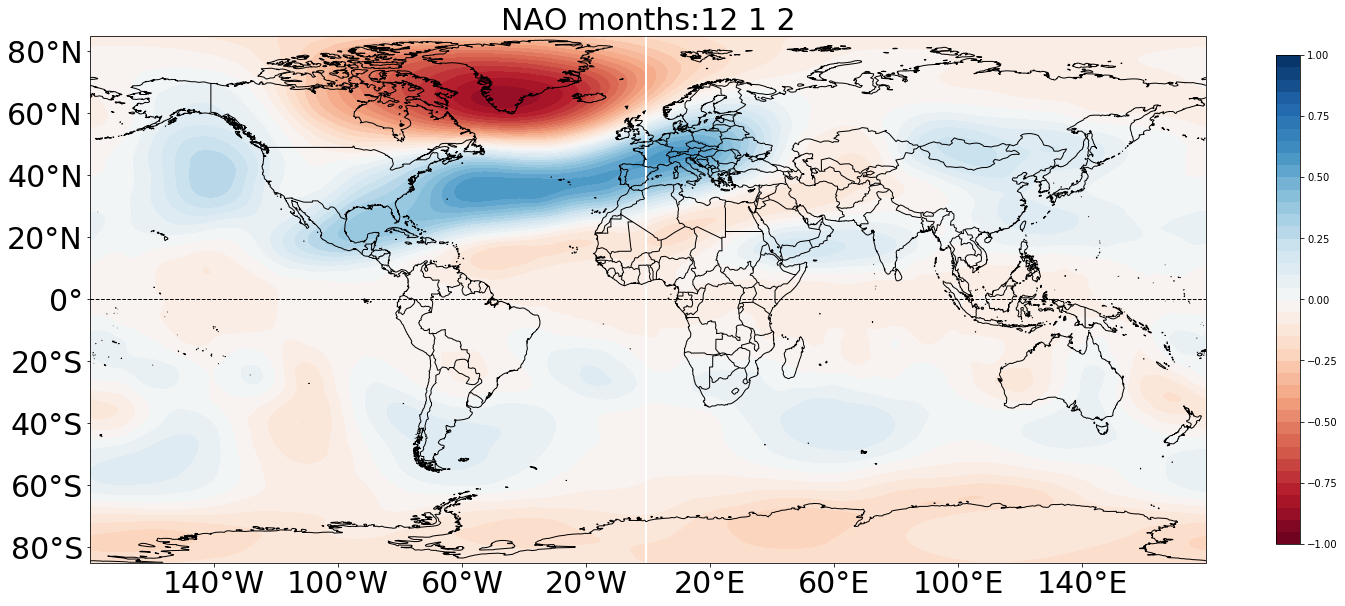

In [12]:
ds_nao = NAO_PCS(reanalysis,season_months,varnam)

doing:  [12, 1, 2]
... rolling DS...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof NAO: 2112.0481322969117
flipping PNA [12, 1, 2]
..loading global...
correlating


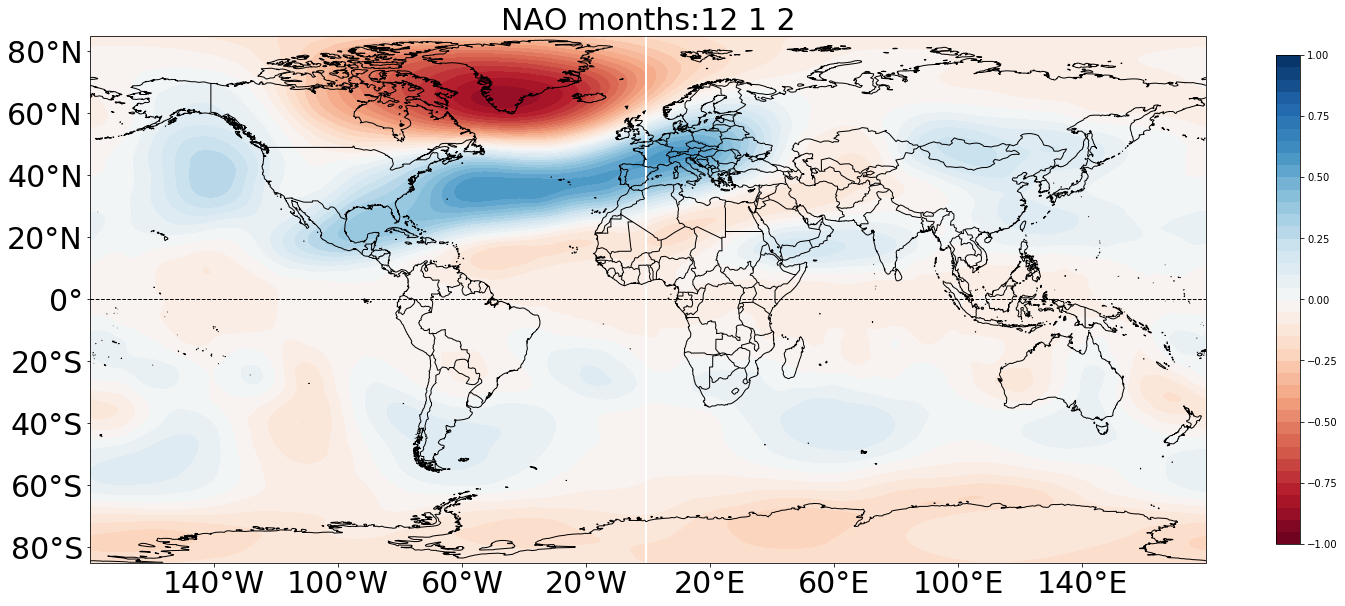

In [13]:
ds_nao = NAO_PCS(reanalysis,season_months,varnam)

## PNA

In [14]:
varnam = 'ZG'
verifdata = "ERA5" #can be ERA5 or CPC
reanalysis = xr.open_zarr("/glade/campaign/cesm/development/cross-wg/S2S/jaye/"+verifdata+".zg_500.zarr/")

In [15]:
#fpath='/glade/campaign/cesm/collections/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/daily/Z500/'
#files = sorted(glob.glob(fpath+'*B1850C5CN*'))
#ds_pna_npo.to_netcdf('/glade/work/wchapman/ASP_summerschool/datasets/PNA_NPO_500_1000.nc')

In [16]:
season_months = [[12,1,2],[3,4,5],[6,7,8],[9,10,11]]
season_months = [[12,1,2]]

doing:  [12, 1, 2]
...opening/selecting month!...
... slicing to region ...
... Time Mean ...
...creating anomaly...
...Decomposing Modes...
...loading daily...
sum eof PNA: -216.0410786364419
sum eof NPO: -433.13277224710896
..loading global...
correlating


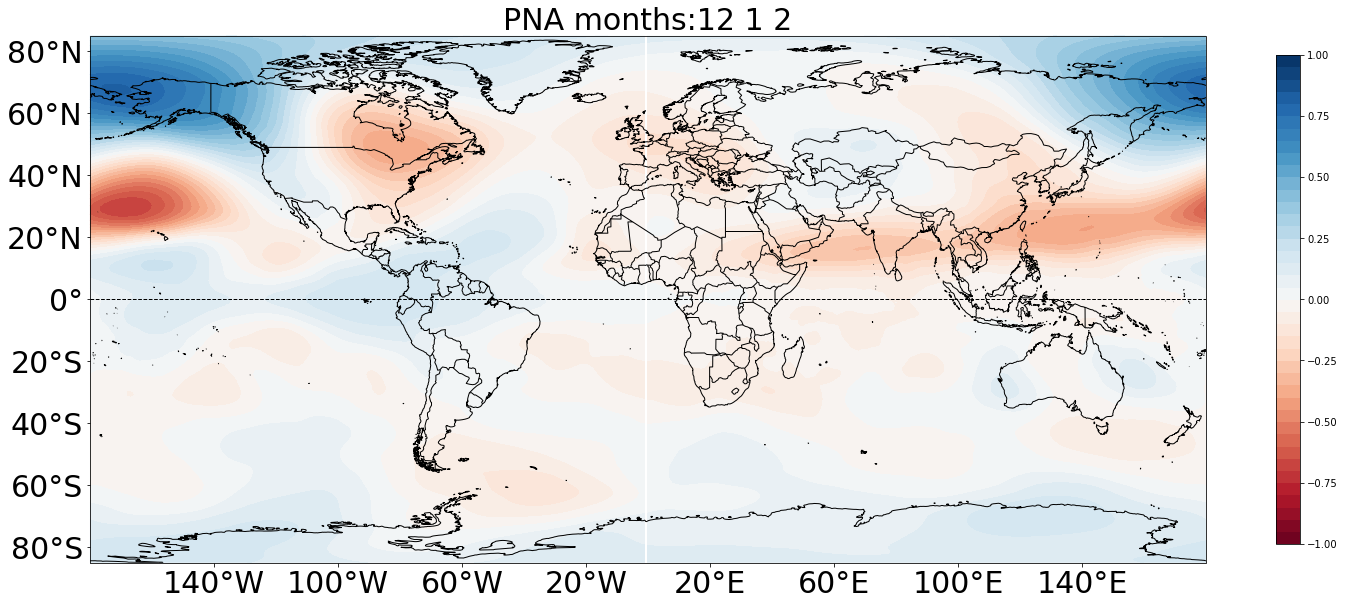

In [17]:
ds_pna_npo = PNA_NPO_PCS(reanalysis,season_months,'ZG')

# Save indexes

In [18]:
import os.path
path="/glade/work/berner/ASP2021_tutorials/s2s_verif_and_data/data/"

In [27]:
ds_pna_npo['PNA'].to_netcdf(os.path.join(path, 'PNA_index2.nc'))
ds_nao.to_netcdf(os.path.join(path, 'NAO_index2.nc'))#,mode='a')

## Select forecasts for which inital time (either days or bi-weekly average) projects on +PNA

In [ ]:
thresh = 1
PNA = np.array(ds_pna_npo.PNA)

In [ ]:
indis = np.where(ds_pna_npo['PNA']>thresh)
hindcast_PNA_pos_subset=reanalysis.sel(time=reanalysis.time[indis])

In [ ]:
hindcast_PNA_pos_subset.to_netcdf(os.path.join(path, 'indexfield_PNA_pos.nc'))

In [ ]:
indis = np.where(ds_pna_npo['PNA']<-thresh)
hindcast_PNA_neg_subset=reanalysis.sel(time=reanalysis.time[indis])

In [ ]:
hindcast_PNA_neg_subset.to_netcdf(os.path.join(path, 'indexfield_PNA_neg.nc'))

In [ ]:
indis = np.where((ds_pna_npo['PNA']>-thresh) & (ds_pna_npo['PNA']<thresh))
hindcast_PNA_neutral_subset=reanalysis.sel(time=reanalysis.time[indis])

In [ ]:
hindcast_PNA_neutral_subset.to_netcdf(os.path.join(path, 'indexfield_PNA_neutral.nc'))

## Select forecasts for which inital time (either days or bi-weekly averages) projects on +NAO

In [ ]:
thresh = 1
indis = np.where(ds_nao['NAO']>thresh)
hindcast_NAO_pos_subset=reanalysis.sel(time=reanalysis.time[indis])

In [ ]:
hindcast_NAO_pos_subset.to_netcdf(os.path.join(path, 'indexfield_NAO_pos.nc'))

In [ ]:
indis = np.where(ds_nao['NAO']<-thresh)
hindcast_NAO_neg_subset=reanalysis.sel(time=reanalysis.time[indis])

In [ ]:
hindcast_NAO_neg_subset.to_netcdf(os.path.join(path,'indexfield_NAO_neg.nc'))

In [ ]:
indis = np.where((ds_nao['NAO']>-thresh) & (ds_nao['NAO']<thresh))
hindcast_NAO_neutral_subset=reanalysis.sel(time=reanalysis.time[indis])

In [ ]:
hindcast_NAO_neutral_subset.to_netcdf(os.path.join(path, 'indexfield_NAO_neutral.nc'))

## Get indeces for states which project neither onto NAO or PNA

In [ ]:
indis = np.where((ds_nao['NAO']>-thresh) & (ds_nao['NAO']<thresh) & (ds_pna_npo['PNA']>-thresh) & (ds_pna_npo['PNA']<thresh) )
hindcast_NAO_neutral_subset=reanalysis.sel(time=reanalysis.time[indis])


In [ ]:
hindcast_NAO_neutral_subset.to_netcdf(os.path.join(path, 'indexfield_NAO_and_PNA_neutral.nc'))

In [ ]:
# some checks

In [ ]:
(hindcast_PNA_pos_subset.ZG.mean("time")-hindcast_PNA_neg_subset.ZG.mean("time")).plot()